In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import src
import src.constants as const
import numpy as np
import time, datetime
from typing import Callable
import dill
from numba.decorators import njit
start = time.time()

#Constants
length_of_price_grid = 10
min_price, max_price = 0.5, 1.5
n_of_lambdas_per_dim = 3
max_iters = 3
error_tol = 1e-5

#Base functions
def period_profit(p: np.ndarray, lambdas: np.ndarray, betas_transition=const.betas_transition):
    """
    Correct expected period return profit. See ReadMe for derivation
    """
    constant_part = (p-const.c) * np.e ** const.α * np.e ** ((const.σ_ɛ ** 2) / 2)
    summation = np.dot(np.e**(betas_transition*np.log(p[:, np.newaxis])), lambdas)

    return constant_part*summation

def naive_period_profit(p: np.ndarray, lambdas: np.ndarray, betas_transition=const.betas_transition):
    exp_beta = np.dot(lambdas, betas_transition)
    return (p-const.c)*np.e**(const.α + exp_beta*np.log(p))
    

def myopic_price(lambdas: np.ndarray, betas_transition=const.betas_transition):
    """
    Given a lambda point, spits out optimal myopic price
    """
    #Elasticity implied by lambdas
    elasticity = np.dot(lambdas, betas_transition) #-2.2
    assert elasticity < -1.0
    return const.c / (1 + (1/elasticity))


def v0(lambdas_except_last: np.ndarray) -> Callable:
    """

    :param lambdas_except_last: D-1, then augmented
    :return:
    """
    #print("---")
    full_lambdas = np.array(list(lambdas_except_last) + [1 - lambdas_except_last.sum()])
    #print(full_lambdas)
    optimal_price: float = myopic_price(full_lambdas)
    #print(optimal_price)

    #Dirty trick because period_profit takes a vector price, not scalar
    prices = np.array([optimal_price, optimal_price+0.01])
    return period_profit(prices, full_lambdas)[0]

## Naive vs real period profit

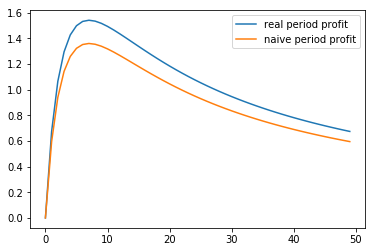

In [20]:
lambdas_selected = np.array([[0., 0.5],
                            [0.1, 0.5],
                            [0.2, 0.5],
                            [0.3, 0.5],
                            [0.4, 0.5],
                             [0.5, 0.4],
                             [0.6, 0.3],
                             [0.7, 0.2],
                             [0.8, 0.1],
                             [0.9, 0.1],
                             [1., 0.]
                            ])

lambda1 = lambdas_selected[:, 0]

fig, ax = plt.subplots(1, 1)
one_lambda = np.array([0., 0., 1.])
prices = np.linspace(0.5, 4)
ax.plot(period_profit(prices, one_lambda), label="real period profit")
ax.plot(naive_period_profit(prices, one_lambda), label="naive period profit")
ax.legend()
#[0.9, 0.1, 0.]: 1.75, 1.5
#[0., 0.1, 0.9]: 1.6, 1.2

In [22]:
test_lambdas = np.array([0.2, 0.7, 0.1])
myopic_price(test_lambdas)

0.82258064516129026

In [23]:
period_profit(np.array([0.9, 1]), test_lambdas)

array([ 1.61249277,  1.54010842])

Simplex points & price grid:

In [24]:
simplex_points = src.generate_simplex_3dims(5)
price_grid = np.linspace(min_price, max_price, num=length_of_price_grid)

In [25]:
print(simplex_points)

[[ 0.    0.    1.  ]
 [ 0.    0.25  0.75]
 [ 0.    0.5   0.5 ]
 [ 0.    0.75  0.25]
 [ 0.    1.    0.  ]
 [ 0.25  0.    0.75]
 [ 0.25  0.25  0.5 ]
 [ 0.25  0.5   0.25]
 [ 0.25  0.75  0.  ]
 [ 0.5   0.    0.5 ]
 [ 0.5   0.25  0.25]
 [ 0.5   0.5   0.  ]
 [ 0.75  0.    0.25]
 [ 0.75  0.25  0.  ]
 [ 1.    0.    0.  ]]


In [26]:
lambdas_selected = np.array([[0., 0.5],
                            [0.1, 0.5],
                            [0.2, 0.5],
                            [0.3, 0.5],
                            [0.4, 0.5],
                             [0.5, 0.4],
                             [0.6, 0.3],
                             [0.7, 0.2],
                             [0.8, 0.1],
                             [0.9, 0.1],
                             [1., 0.]
                            ])

lambda1 = lambdas_selected[:, 0]
v0_values = np.empty(lambdas_selected.shape[0])
for i, l in enumerate(lambdas_selected):
    v0_values[i] = v0(l)

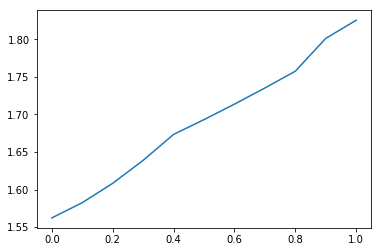

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(lambda1, v0_values)

In [28]:
print(v0_values)

[ 1.56223469  1.58250175  1.60827274  1.63879842  1.67335964  1.69301569
  1.7136339   1.73513772  1.75745367  1.80114727  1.82531369]


In [31]:
v1 = src.bellman_operator(v0, price_grid, simplex_points, period_profit)
v1

doing 0 of 15
doing 10 of 15


(<scipy.interpolate.interpnd.LinearNDInterpolator at 0x181e2194e0>,
 array([ 1.05555556,  0.94444444,  0.94444444,  0.94444444,  0.94444444,
         0.94444444,  0.94444444,  0.94444444,  0.83333333,  0.94444444,
         0.83333333,  0.83333333,  0.83333333,  0.83333333,  0.83333333]))